# Introduction à Brian partie 2: Synapses

## Dérivé du tutoriel fournit par Brian

### Objectifs du tutoriel :
**1) Instancier des objets de type ``Synapses``**

**2) Ajouter des poids aux ``Synapses``**

**3) Générer des connectivités avec ``connect``**

**4) Visualiser la connectivité**

**5) Implémenter et étudier le modèle de plasticité synaptique STDP**

In [9]:
from brian2 import *
%matplotlib inline

## La synapse la plus simple
Un réseau de neurones est constitué d'un groupe de neurones et d'un groupe de synapses. Jusqu'à présent nous n'avons que généré des groupes de neurones, maintenant nous allons les interconnecter avec des synapses.

On commence par un modèle de synapse très simple, qui cause un changement instantané du potentiel postsynaptique.

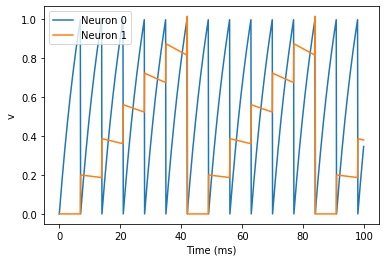

In [10]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Commentez ces deux lignes pour voir ce qu'il se passe sans Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

Remarquez qu'on a instancié 2 neurones avec la même équation différentielle mais avec des valeurs de paramètres différents pour I et tau. Neurone 0 a ``I=2`` et ``tau=10*ms`` ce qui conduit ce neurone à émettre des spikes a une fréquence assez élevée. Neurone 1 a ``I=0`` et ``tau=100*ms`` ce qui signifie qu'il ne recoit pas de courant extérieur et que sans synapse ce neurone n'émettra jamais de spike.

Ensuite on définit les synapses: ``Synapses(source, target, ...)`` veut dire qu'on définit un modèle de synapse qui associe une ``source`` à sa ``cible``. Ici, la source et la cible sont issues du même groupe de neurone ``G``.
``on_pre='v_post += 0.2'`` veut dire que quand un spike est émis par neurone présynaptique (``on_pre``) cela conduit à un changement instantané du potentiel du neurone postsynaptique (``v_post``). Notez que le suffixe ``_post`` permet d'accéder et de modifier une variable postsynaptique, ici on incrémente la variable ``v`` du neurone postsynaptique de 0.2. Pour résumer, lorsque la source (i.e. le neurone 0) émet un spike, la variable ``v`` de la cible (i.e. le neurone 1) va être incrémentée instantanément de 0.2.

**Cependant, pour le moment on a défini le modèle de synapse mais on n'a pas créé de synapse.** 
C'est la ligne ``S.connect(i=0, j=1)`` qui permet de créer une synapse du neurone 0 vers le neurone 1.

## Ajouter un poids synaptique

Dans la section précédente on a fixé la valeur du poids de la synapse à 0.2.
Cependant, la plupart du temps on veut faire varier le poids suivant des règles de plasticité synaptique. Cela implique que le poids doit être une variable et pas une constante.

Pour réaliser cela, on a besoin d'un modèle de synapse introduisant un poids. Voyons un exemple :

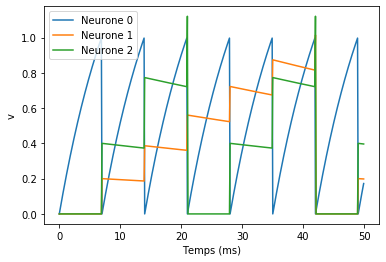

In [11]:
start_scope()

neuron_model = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''

synapse_model = '''
w = j*0.2 : 1
'''

G = NeuronGroup(3, model = neuron_model, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, model = synapse_model, on_pre='v_post += w')
S.connect(i=0, j=[1, 2])

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neurone 0')
plot(M.t/ms, M.v[1], label='Neurone 1')
plot(M.t/ms, M.v[2], label='Neurone 2')
xlabel('Temps (ms)')
ylabel('v')
legend();

On a créé un modèle de synapse contenant un poids synaptique correspondant à la variable ``w``. La valeur de ce poids est fonction de l'indice ``j``, qui correspond à l'indice des neurones cibles.
Par exemple, si on connecte le neurone 0 au neurone 2, cela donnera une connection avec un poids de ``0.4 = 0.2 * 2``. 

Notez que pour un objet ``Synapses``, ``i`` et ``j`` réfèrent respectivement à l'index du neurone source et à l'index du neurone cible.

On a changé le comportement lors de l'émission d'un spike avec ``on_pre='v_post += w'`` de telle sorte que chaque synapse se comporte de façon différente suivant la valeur du poids ``w``. Ainsi, lors de l'émission d'un spike depuis un neurone présynaptique, la variable ``v`` du neurone postsynaptique va être incrémentée par le poids ``w`` de la synapse.

## Générer et visualiser des connectivités plus complexes
Jusqu'à présent, on a fixé la connectivité explicitement (e.g. connection du Neurone 0 vers Neurone 1). Cependant cette syntaxe est fastidieuse lorsqu'on veut créer de plus grands réseaux. 

On va voir qu'on peut générérer des connectivités complexes en passant des conditions via l'argument ``condition`` de ``connect`` et/ou des probabilités via l'argument ``p`` de ``connect``.

In [12]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

``S.connect(condition='i!=j', p=0.2)`` signifie qu'on connecte toutes les paires de neurones ``i`` et ``j`` avec une probabilité de 0.2 qui respectent la condition ``i!=j``, i.e. l'index du neurone cible et l'index du neurone source doivent être différent.

Maintenant visualisons la connectivité résultante :

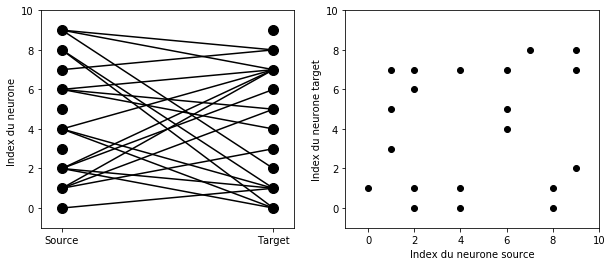

In [16]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Index du neurone ')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Index du neurone source')
    ylabel('Index du neurone target')
    
visualise_connectivity(S)

Les deux graphiques sont deux manières différentes de représenter la même connectivité.

A gauche : une synapse est représentée par une ligne.

A droite : une synapse est représentée par un point noir.

Observez comment ces graphiques changent en changeant la probabilité de connection entre deux neurones (respectivement 0.1, 0.5 et 1.0) :

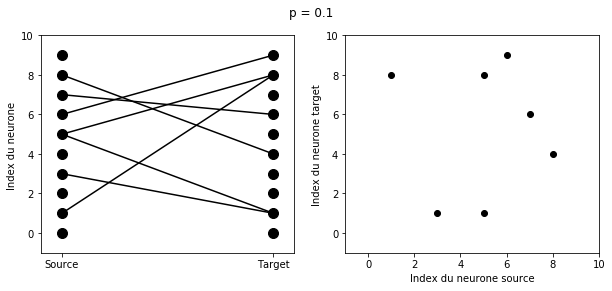

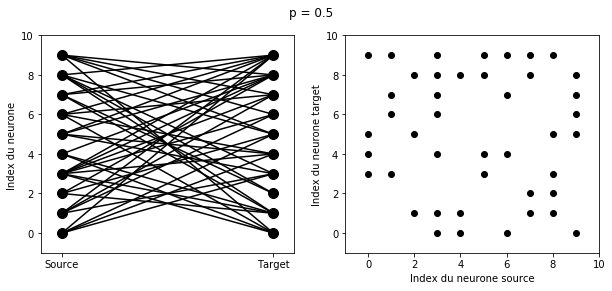

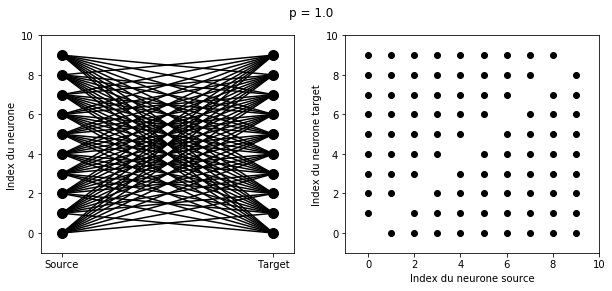

In [17]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

## Un modèle de plasticité synaptique plus complexe: la STDP (spike-timing dependent plasticity).

La STDP est définie par une équation ressemblant à:

$$\Delta w = \sum_{t_{pre}} \sum_{t_{post}} W(t_{post}-t_{pre})$$

On observe que la variation du poids synaptique $\Delta w$ est la somme sur tout les temps présynaptiques $t_{pre}$ et postsynaptique $t_{post}$ d'une fonction $W$ de la différence $\Delta t$ entre les temps d'émissions de spikes postsynaptique et présynaptique.

La fonction $W$ qu'on utilisera est :

$$W(\Delta t) = \begin{cases}
A_{pre} e^{-\Delta t/\tau_{pre}} & \Delta t>0 \\
-A_{post} e^{\Delta t/\tau_{post}} & \Delta t<0
\end{cases}$$

Graphiquement la fonction $W$ ressemble à :

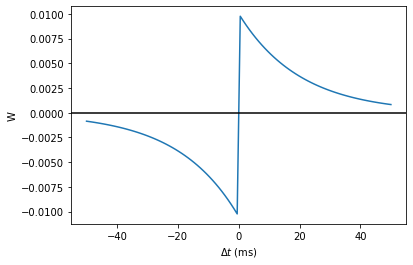

In [18]:
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre*1.05
delta_t = linspace(-50, 50, 100)*ms
W = where(delta_t>0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
plot(delta_t/ms, W)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k');

Nous allons reformuler la règle STDP d'une façon plus efficace d'un point de vue computationnel et également plus réaliste d'un point de vue physiologique: 

On définit deux nouvelles variables $a_{pre}$ et $a_{post}$ qui sont des "traces" (ou mémoire) de l'activité pré- et post-synaptique, gouvernée par les équations différentielles:
$$
\begin{align}
\tau_{pre}\frac{\mathrm{d}}{\mathrm{d}t} a_{pre} &= -a_{pre}\\
\tau_{post}\frac{\mathrm{d}}{\mathrm{d}t} a_{post} &= -a_{post}
\end{align}
$$

Quand un spike présynaptique est émis, la trace présynaptique est actualisée et le poids synaptique est modifié suivant la règle : 

$$
\begin{align}
a_{pre} &\rightarrow a_{pre}+A_{pre}\\
w &\rightarrow w+a_{post}
\end{align}
$$

Quand un spike postsynaptique est émis, la règle suivante est appliquée :

$$
\begin{align}
a_{post} &\rightarrow a_{post}+A_{post}\\
w &\rightarrow w+a_{pre}
\end{align}
$$

Maintenant implémentons cette formulation "Brian-friendly", car basée sur des équations différentielles et des spikes :

In [19]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*1.05

G = NeuronGroup(1, 'v:1', threshold='v>1')

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')

On peut constater que le modèle de la synapse définit bien nos 3 variables ``w``, ``apre`` and ``apost``. On a ajouté aussi ``(event-driven)`` après les définitions de ``apre`` et ``apost``. Cela signifie que les variables ``apre`` et ``apost`` ne seront actualisées que lorsqu'un spike est émis, ce qui est plus efficient d'un point de vue computationnel (plutôt que de les actualiser à chaque pas de temps).

Ensuite nous avons l'agument ``on_pre=...``. La première ligne est ``v_post += w``: on ajoute ici la valeur du poids  à la variable ``v`` du neurone postsynaptique. La seconde ligne est ``apre += Apre`` qui encode la règle pour la variation de la trace présynaptique. La troisième ligne encode la suite de la règle mais on a rajouté une propriété supplémentaire : les poids synaptiques sont bornés entre un minimum de 0 et un maximum de ``wmax`` pour que les poids ne divergent pas ou qu'ils soient négatifs. La fonction ``clip(x, min, max)`` réalise cela.

Enfin, on a l'argument ``on_post=...`` . Cela donne les instructions a calculer lorsqu'un neurone postsynaptique émet un spike. Dans ce cas (contrairement à ``on_pre``), on ne modifie pas la variable neuronale ``v``, mais uniquement les variables synaptiques (ici la trace ``apost`` et le poids ``w``).

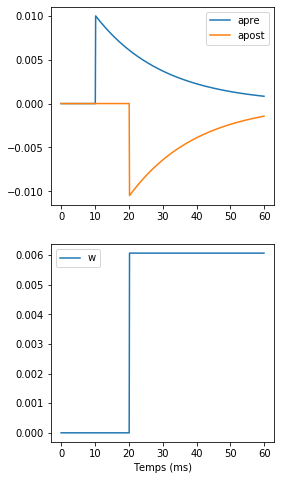

In [47]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(60*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Temps (ms)');

Dans le premier graphique, on observe l'évolution des traces ``apre(t)`` et ``apost(t)``.

Dans le second graphique, on observe l'évolution du poids ``w(t)``.

Expliquez l'évolution de ces variables.

Inversez l'ordre d'émission des spikes des deux neurones et observez le résultat. Expliquez ce qu'il se passe.